Cell 1: Đọc và xử lý dữ liệu, chuẩn bị feature

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

TRAIN_FILE = "../../../Dataset/Splits/train_80_10_10.csv"
VAL_FILE   = "../../../Dataset/Splits/val_80_10_10.csv"
TEST_FILE  = "../../../Dataset/Splits/test_80_10_10.csv"

train_df = pd.read_csv(TRAIN_FILE, parse_dates=["Date"])
val_df = pd.read_csv(VAL_FILE, parse_dates=["Date"])
test_df = pd.read_csv(TEST_FILE, parse_dates=["Date"])

def parse_value(x):
    if isinstance(x, str):
        s = x.replace('$','').replace(',','')
        if s.endswith('%'): return float(s[:-1])
        if s.endswith('K'): return float(s[:-1]) * 1e3
        if s.endswith('M'): return float(s[:-1]) * 1e6
        return float(s)
    return x

def clean_df(df):
    df = df.copy()
    for col in df.columns:
        if df[col].dtype == object:
            df[col] = df[col].apply(parse_value)
    return df

train_df = clean_df(train_df)
val_df = clean_df(val_df)
test_df = clean_df(test_df)

df_all = pd.concat([train_df, val_df, test_df]).sort_values("Date").reset_index(drop=True)

# Thay NaN ở cột Vol. bằng giá trị trung bình
vol_mean = df_all['Vol.'].mean()
df_all['Vol.'].fillna(vol_mean, inplace=True)

# Tạo các thuộc tính mới (nếu bạn muốn giữ)
df_all["day_of_week"] = df_all["Date"].dt.dayofweek
df_all["month"] = df_all["Date"].dt.month
df_all["rolling_mean_5"] = df_all["Price"].rolling(window=5).mean()
df_all["rolling_std_5"] = df_all["Price"].rolling(window=5).std()
df_all["return_1d"] = df_all["Price"].pct_change()

# Bỏ các dòng vẫn còn NaN (do rolling, pct_change)
df_all.dropna(inplace=True)

feature_cols = ["Price", "Open", "High", "Low", "Vol.", "Change %", "CPIAUCSL",
                "day_of_week", "month", "rolling_mean_5", "rolling_std_5", "return_1d"]

scaler = StandardScaler()
df_all[feature_cols] = scaler.fit_transform(df_all[feature_cols])


C:\Users\quyen\AppData\Local\Temp\ipykernel_27992\1852761327.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_all['Vol.'].fillna(vol_mean, inplace=True)


Cell 2: Chuẩn bị dữ liệu chuỗi (lagged) và feature tóm tắt cho MLP

In [2]:
SEQ_LEN = 90

def create_multivariate_lagged(data, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i, :])
        y.append(data[i, 0])  # target Price
    return np.array(X), np.array(y)

X_all, y_all = create_multivariate_lagged(df_all[feature_cols].values, SEQ_LEN)

def create_summary_features(data, window, summary_cols_idx):
    summary_X = []
    for i in range(window, len(data)):
        summary_X.append(data[i-1, summary_cols_idx])
    return np.array(summary_X)

summary_feature_names = ["rolling_mean_5", "rolling_std_5", "return_1d"]
summary_cols_idx = [feature_cols.index(c) for c in summary_feature_names]

summary_features_all = create_summary_features(df_all[feature_cols].values, SEQ_LEN, summary_cols_idx)

n_train = len(train_df) - SEQ_LEN
n_val = len(val_df)

X_train = X_all[:n_train]
X_val = X_all[n_train:n_train+n_val]
X_test = X_all[n_train+n_val:]

y_train = y_all[:n_train]
y_val = y_all[n_train:n_train+n_val]
y_test = y_all[n_train+n_val:]

summary_train = summary_features_all[:n_train]
summary_val = summary_features_all[n_train:n_train+n_val]
summary_test = summary_features_all[n_train+n_val:]


Cell 3: Tạo DataLoader PyTorch

In [3]:
import torch
from torch.utils.data import DataLoader, TensorDataset

train_loader = DataLoader(TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(summary_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32)
), batch_size=32, shuffle=False)

val_loader = DataLoader(TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(summary_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.float32)
), batch_size=32)

test_loader = DataLoader(TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(summary_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.float32)
), batch_size=32)


Cell 4: Định nghĩa mô hình WaveNet + MLP Hybrid

In [4]:
import torch.nn as nn

class WaveNetBlock(nn.Module):
    def __init__(self, dilation, in_ch, out_ch, kernel_size=2):
        super().__init__()
        self.conv = nn.Conv1d(in_ch, out_ch, kernel_size, dilation=dilation, padding='same')
        self.relu = nn.ReLU()
        self.skip = nn.Conv1d(out_ch, in_ch, kernel_size=1)

    def forward(self, x):
        out = self.relu(self.conv(x))
        skip = self.skip(out)
        if skip.size(2) != x.size(2):
            min_len = min(skip.size(2), x.size(2))
            x = x[:, :, :min_len]
            skip = skip[:, :, :min_len]
        return x + skip, skip

class WaveNet(nn.Module):
    def __init__(self, in_ch, out_ch=32, dilations=[1, 2, 4, 8]):
        super().__init__()
        self.blocks = nn.ModuleList([
            WaveNetBlock(d, in_ch, out_ch) for d in dilations
        ])
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(in_ch, 1)

    def forward(self, x):
        x = x.transpose(1, 2)  # (batch, channels, seq_len)
        skip_total = None
        for block in self.blocks:
            x, skip = block(x)
            skip_total = skip if skip_total is None else skip_total + skip
        x = self.dropout(skip_total)
        x = x.mean(dim=2)  # global average pooling over seq_len
        return self.fc(x).squeeze(1)

class MLP(nn.Module):
    def __init__(self, in_features, hidden_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.net(x)

class WaveNetMLPHybrid(nn.Module):
    def __init__(self, wavenet_in_ch, mlp_in_ch, mlp_hidden=32):
        super().__init__()
        self.wavenet = WaveNet(wavenet_in_ch)
        self.mlp = MLP(mlp_in_ch, mlp_hidden)
        self.fc = nn.Linear(1 + mlp_hidden, 1)

    def forward(self, x_seq, x_summary):
        w_out = self.wavenet(x_seq)  # (batch,)
        m_out = self.mlp(x_summary)  # (batch, mlp_hidden)
        combined = torch.cat([w_out.unsqueeze(1), m_out], dim=1)
        return self.fc(combined).squeeze(1)


Cell 5: Khởi tạo model, optimizer, loss

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = WaveNetMLPHybrid(wavenet_in_ch=X_train.shape[2], mlp_in_ch=summary_train.shape[1]).to(device)

import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


Cell 6: Huấn luyện model

In [6]:
from tqdm import tqdm

EPOCHS = 100
best_val_loss = float("inf")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for X_seq_batch, X_sum_batch, y_batch in train_loader:
        X_seq_batch, X_sum_batch, y_batch = X_seq_batch.to(device), X_sum_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_seq_batch, X_sum_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_seq_batch.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_seq_batch, X_sum_batch, y_batch in val_loader:
            X_seq_batch, X_sum_batch, y_batch = X_seq_batch.to(device), X_sum_batch.to(device), y_batch.to(device)
            y_pred = model(X_seq_batch, X_sum_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item() * X_seq_batch.size(0)

    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_wavenet_mlp.pt")


c:\Users\quyen\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ..\aten\src\ATen\native\Convolution.cpp:1004.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch 01 | Train Loss: 0.441773 | Val Loss: 0.695598
Epoch 02 | Train Loss: 0.356645 | Val Loss: 0.613285
Epoch 03 | Train Loss: 0.249578 | Val Loss: 0.478953
Epoch 04 | Train Loss: 0.129131 | Val Loss: 0.294222
Epoch 05 | Train Loss: 0.064439 | Val Loss: 0.132309
Epoch 06 | Train Loss: 0.040511 | Val Loss: 0.046638
Epoch 07 | Train Loss: 0.032077 | Val Loss: 0.024649
Epoch 08 | Train Loss: 0.029467 | Val Loss: 0.022527
Epoch 09 | Train Loss: 0.027684 | Val Loss: 0.022457
Epoch 10 | Train Loss: 0.026235 | Val Loss: 0.022755
Epoch 11 | Train Loss: 0.025060 | Val Loss: 0.023178
Epoch 12 | Train Loss: 0.023944 | Val Loss: 0.023298
Epoch 13 | Train Loss: 0.022911 | Val Loss: 0.023529
Epoch 14 | Train Loss: 0.021751 | Val Loss: 0.023890
Epoch 15 | Train Loss: 0.020952 | Val Loss: 0.023912
Epoch 16 | Train Loss: 0.019997 | Val Loss: 0.023904
Epoch 17 | Train Loss: 0.019317 | Val Loss: 0.023998
Epoch 18 | Train Loss: 0.018592 | Val Loss: 0.024002
Epoch 19 | Train Loss: 0.017648 | Val Loss: 0.

Cell 7: Đánh giá trên test set

In [8]:
# %% [markdown]
# # Cell 7: Đánh giá trên test set (Dữ liệu gốc)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# %%
model.load_state_dict(torch.load("best_wavenet_mlp.pt"))
model.eval()

y_preds = []
y_trues = []

with torch.no_grad():
    for X_seq_batch, X_sum_batch, y_batch in test_loader:
        X_seq_batch, X_sum_batch = X_seq_batch.to(device), X_sum_batch.to(device)
        y_pred = model(X_seq_batch, X_sum_batch).cpu().numpy()
        y_preds.extend(y_pred)
        y_trues.extend(y_batch.numpy())

y_preds = np.array(y_preds)
y_trues = np.array(y_trues)

# Trả về dữ liệu gốc
y_preds_inv = y_preds * scaler.scale_[0] + scaler.mean_[0]
y_trues_inv = y_trues * scaler.scale_[0] + scaler.mean_[0]

mae = mean_absolute_error(y_trues_inv, y_preds_inv)
rmse = mean_squared_error(y_trues_inv, y_preds_inv, squared=False)
mape = np.mean(np.abs((y_trues_inv - y_preds_inv) / y_trues_inv)) * 100
r2 = r2_score(y_trues_inv, y_preds_inv)
n = len(y_trues_inv)
p = X_train.shape[2]
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"MAE       : {mae:.4f}")
print(f"RMSE      : {rmse:.4f}")
print(f"MAPE      : {mape:.2f}%")
print(f"R²        : {r2:.4f}")
print(f"Adj R²    : {adj_r2:.4f}")


MAE       : 102.0417
RMSE      : 132.5905
MAPE      : 3.89%
R²        : 0.8347
Adj R²    : 0.8294


Cell 8: Dự báo 90 ngày tương lai

In [9]:
# %% [markdown]
# # Cell 8: Dự báo 90 ngày (Dữ liệu gốc)

# %%
model.eval()
input_seq = torch.tensor(X_test[-1:], dtype=torch.float32).to(device)
input_sum = torch.tensor(summary_test[-1:], dtype=torch.float32).to(device)

forecast_scaled = []

with torch.no_grad():
    for _ in range(90):
        y_next = model(input_seq, input_sum).cpu().item()
        forecast_scaled.append(y_next)

        new_input_seq = input_seq[:, 1:, :].clone()
        new_step_seq = new_input_seq[:, -1:, :].clone()
        new_step_seq[:, :, 0] = y_next
        input_seq = torch.cat([new_input_seq, new_step_seq], dim=1)

        input_sum = input_sum.clone()

forecast_inv = np.array(forecast_scaled) * scaler.scale_[0] + scaler.mean_[0]


Cell 9: Vẽ biểu đồ kết quả

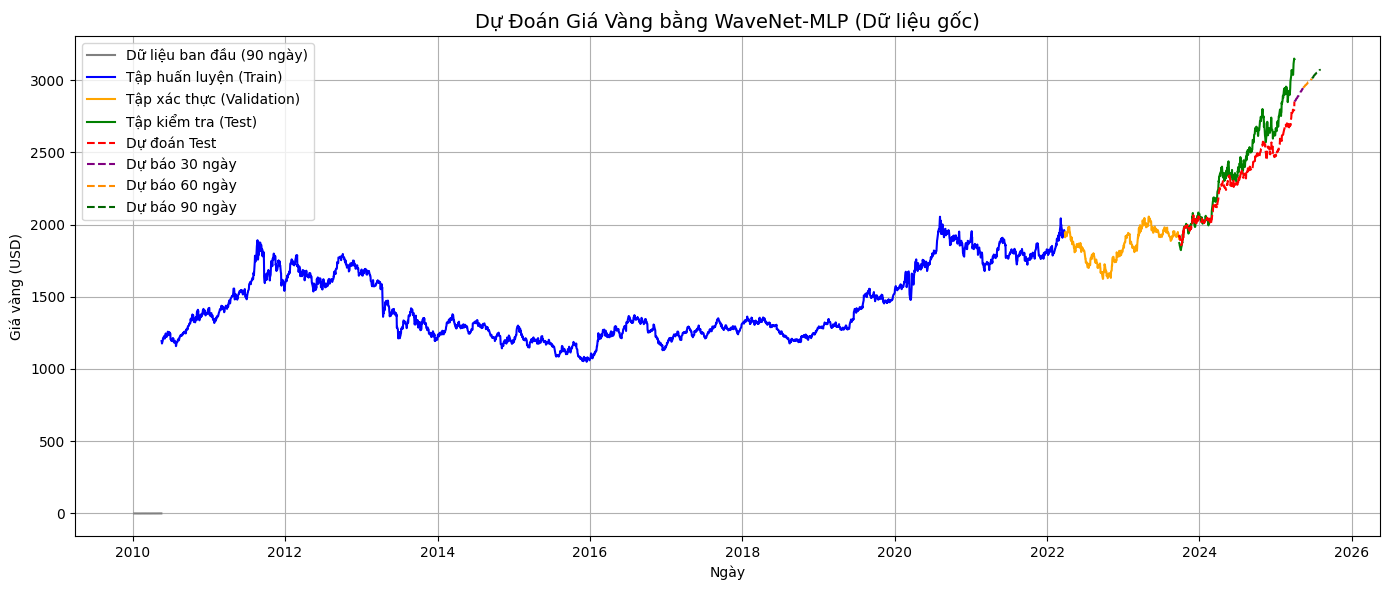

In [10]:
# %% [markdown]
# # Cell 9: Vẽ biểu đồ kết quả (Dữ liệu gốc, Date đồng bộ)

# %%
import matplotlib.pyplot as plt
import numpy as np
from pandas.tseries.offsets import BDay

SEQ_LEN = 90
train_len = len(X_train)
val_len = len(X_val)
test_len = len(X_test)

train_start_idx = SEQ_LEN
val_start_idx = train_start_idx + train_len
test_start_idx = val_start_idx + val_len

train_dates = df_all['Date'].iloc[train_start_idx:train_start_idx + train_len].reset_index(drop=True)
val_dates = df_all['Date'].iloc[val_start_idx:val_start_idx + val_len].reset_index(drop=True)
test_dates = df_all['Date'].iloc[test_start_idx:test_start_idx + test_len].reset_index(drop=True)

# Khai báo target_col để tránh lỗi NameError
target_col = "Price"

plt.figure(figsize=(14, 6))

plt.plot(df_all['Date'][:90], df_all[target_col].values[:90], color='gray', label='Dữ liệu ban đầu (90 ngày)')
plt.plot(train_dates, y_train * scaler.scale_[0] + scaler.mean_[0], color='blue', label='Tập huấn luyện (Train)')
plt.plot(val_dates, y_val * scaler.scale_[0] + scaler.mean_[0], color='orange', label='Tập xác thực (Validation)')
plt.plot(test_dates, y_trues_inv, color='green', label='Tập kiểm tra (Test)')
plt.plot(test_dates, y_preds_inv, color='red', linestyle='--', label='Dự đoán Test')

try:
    last_test_date = pd.to_datetime(test_dates.iloc[-1])
    full_forecast = np.concatenate([y_preds_inv[-1:], forecast_inv])
    full_dates = pd.date_range(last_test_date, periods=len(full_forecast), freq=BDay())

    plt.plot(full_dates[1:31], full_forecast[1:31], color='purple', linestyle='--', label='Dự báo 30 ngày')
    plt.plot(full_dates[31:61], full_forecast[31:61], color='darkorange', linestyle='--', label='Dự báo 60 ngày')
    plt.plot(full_dates[61:], full_forecast[61:], color='darkgreen', linestyle='--', label='Dự báo 90 ngày')
except NameError:
    pass

plt.title("Dự Đoán Giá Vàng bằng WaveNet-MLP (Dữ liệu gốc)", fontsize=14)
plt.xlabel("Ngày")
plt.ylabel("Giá vàng (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
!jupyter nbconvert --to html WaveNet_MLP_80-10-10.ipynb

[NbConvertApp] Converting notebook WaveNet_MLP_80-10-10.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 453099 bytes to WaveNet_MLP_80-10-10.html
